In [1]:
# file: anomaly_scoring_mvset.py
# Author: Anne Sabourin
# Description: unsupervised.mvsets: Anomaly scoring on extremes with  Mass-Volume sets
# Date: May 2025

# Tutorial notebook for anomaly scoring among extremes  with angular mass-volume sets, `unsupervised.mvsets` sub-package.

Implements and illustrates the methodology and theory developed in

    * Thomas, A., Clémençon, S., Gramfort, A., & Sabourin, A. (2017, April). Anomaly Detection in Extreme Regions via Empirical MV-sets on the Sphere. In AISTATS (Vol. 54).

In [2]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import numpy as np
from scipy.interpolate import griddata
import MLExtreme as mlx

## Data generation <a id="Data_generation"></a>

In [3]:
# Regular Variation model with Dirichlet mixture model as a limit angular distribution
# Example: p = 2
n = 10000  # Number of samples
p = 2  # Ambient dimension (2D in this case)
k = 3  # Number of components in the Dirichlet mixture
alpha = 2  # Shape parameter of the radial Pareto distribution

# Angular distribution of extremes: Dirichlet Mixture with means (Mu), log scale (lnu), and weights (wei)
Mu = np.array([[0.5, 0.5]])  # k* p matrix of means
lnu = np.log([50])  # log(10) for both components
wei = np.array([1])  # weights for the mixture components
Mu, wei = mlx.normalize_param_dirimix(Mu, wei)

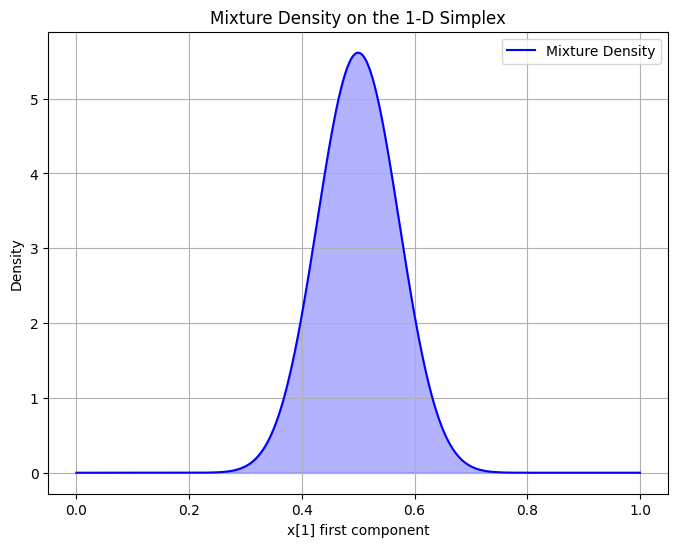

In [4]:
# Visualization of the angular component:
# # inspect the angular density
# Mu_wei = wei  @ Mu
# # Display the result
# print(Mu_wei)
mlx.plot_pdf_dirimix_2D(Mu, wei, lnu)

In [5]:
# Generate the dataset using the gen_rv_dirimix function and parameters specified above. As an adversarial (bulk) angular parameter, choose the center of the simplex
np.random.seed(1)
X = mlx.gen_rv_dirimix(alpha, Mu, wei, lnu, scale_weight_noise=0,
                       size=n)

#  cancel the impact of generating in a L1 norm model and then using an infinite norm convention, for interpretability of results w.r.t. the generating model.
l1 = np.sum(X, axis=1)
linf = np.max(X, axis=1)
X = (X * l1.reshape(-1, 1) / linf.reshape(-1, 1))

X_test = mlx.gen_rv_dirimix(alpha, Mu=(np.ones(p)/p).reshape(1, p),
                            wei=[1], lnu=[np.log(p*2)],
                            scale_weight_noise=0,
                            size=5*n)

l1 = np.sum(X_test, axis=1)
linf = np.max(X_test, axis=1)
X_test = ((X_test) * l1.reshape(-1, 1) / linf.reshape(-1, 1))

## Data pre-processing

In [6]:
# Rank transform the training set and also the test set, where the
# transformation is learnt using the training set only
Xt = mlx.rank_transform(X)
Xt_test = mlx.rank_transform_test(X, X_test)

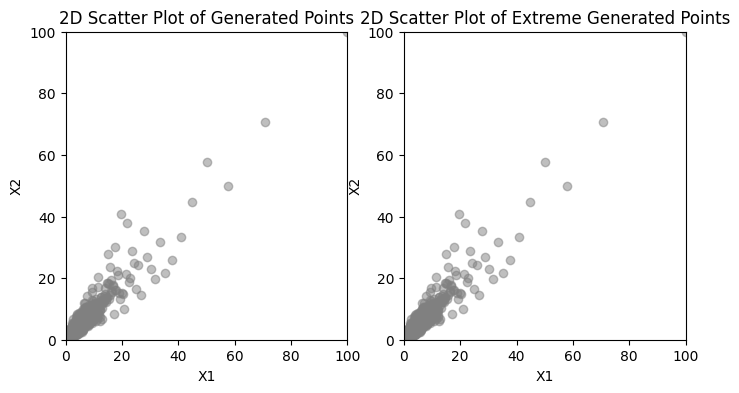

In [7]:
# Display the preprocessed dataset (2D plot), rescale for easier visualization
X_disp = Xt**(alpha/4)
idex = np.max(Xt, axis=1) > 10**(1/alpha)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].scatter(X_disp[:, 0], X_disp[:, 1], color='grey', alpha=0.5)
axs[0].set_xlabel('X1')
axs[0].set_ylabel('X2')
max_range = max(np.max(X_disp[:, 0]), np.max(X_disp[:, 1]))
axs[0].set_xlim(0, max_range)
axs[0].set_ylim(0, max_range)
axs[0].set_title('2D Scatter Plot of Generated Points')
axs[1].scatter(X_disp[idex, 0], X_disp[idex, 1], color='grey', alpha=0.5)
axs[1].set_xlabel('X1')
axs[1].set_ylabel('X2')
max_range = max(np.max(X_disp[idex, 0]), np.max(X_disp[idex, 1]))
axs[1].set_xlim(0, max_range)
axs[1].set_ylim(0, max_range)
axs[1].set_title('2D Scatter Plot of Extreme Generated Points')
plt.show()

## Model training: construct empirical angular mass-volume sets
NB: `J` is the number of histogram cells per dimension.
J should be chosen rather small especially when d>2 because the total number of cells is  d * J**(d-1)

In [8]:
J = 4
radii = np.max(Xt, axis=1)
thresh_train = np.quantile(radii, q=1 - 1/100)
ad_mv = mlx.Xmvset(J=J, thresh_train=thresh_train, thresh_predict=thresh_train)
ad_mv.fit(Xt)

In [9]:
# Output visualization
# ad_mv.masses
# ad_mv.coords
# np.cumsum(ad_mv.masses)/ad_mv.number_extremes

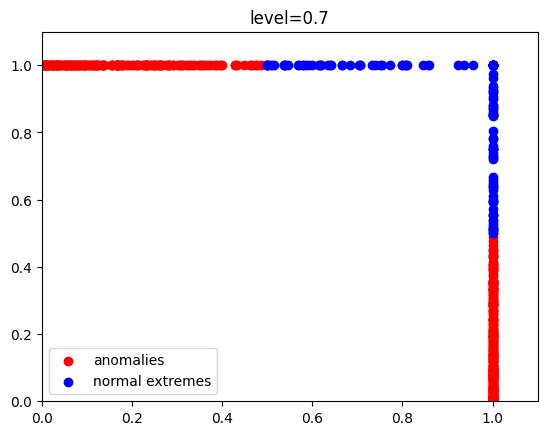

In [10]:
# Display the mv-sets on the sphere
level = 0.7
y_ext, Xt_test_ext, mask = ad_mv.predict(Xt_test, alpha=level)
not_y_ext = (1 - y_ext).astype(bool)
y_ext = y_ext.astype(bool)
plt.figure()
Xplot = Xt_test_ext
Rplot = np.max(Xplot, axis=1).reshape(-1, 1)
Xplot = Xplot/Rplot
plt.scatter(Xplot[y_ext, 0], Xplot[y_ext, 1], c="red", label="anomalies")
plt.scatter(Xplot[not_y_ext, 0], Xplot[not_y_ext, 1], c="blue",
            label="normal extremes")
max_val = np.max(Xplot)*1.1
plt.ylim(0, max_val)
plt.xlim(0, max_val)
plt.title(f'level={level}')
plt.legend()
plt.show()

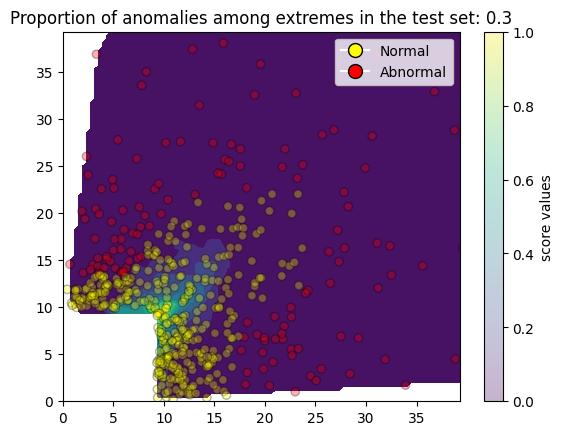

In [11]:
# Contour plots of the score on the positive orthant
y_ext, Xt_test_ext, mask = ad_mv.score(Xt_test, angular_only=False)
level = 0.3
y_thresh = np.quantile(y_ext, level)

plt.figure()
Xplot = X_test[mask]  # change to Xt_test_ext for a plot  on transformed scale
Rplot = np.max(Xplot, axis=1).reshape(-1, 1)
# Xplot = Xplot/Rplot
max_val = np.max(Xplot)*0.2
# # Create a grid of points
x_min, x_max = 0, max_val
y_min, y_max = 0, max_val
xi = np.linspace(x_min, x_max, 100)
yi = np.linspace(y_min, y_max, 100)
xi, yi = np.meshgrid(xi, yi)
# Interpolate the y values onto the grid
zi = griddata(Xplot, y_ext, (xi, yi), method='linear')
# Create a contour plot
plt.contourf(xi, yi, zi, levels=14, cmap='viridis')
# L0 = np.min(Xplot[Xplot[:, 0] >= Xplot[:, 1], 0])
# L1 = np.min(Xplot[Xplot[:, 0] <= Xplot[:, 1], 1])
L = np.min(np.max(Xplot, axis=1))
L0 = L
L1 = L
# Add a white rectangle to mask the region [0, L0] x [0, L1]
rect = patches.Rectangle((0, 0), L0, L1, linewidth=1,
                         edgecolor='none', facecolor='white')
plt.gca().add_patch(rect)
color = ["yellow" if y_ext[i] > y_thresh else "red" for i in range(len(y_ext))]
plt.scatter(Xplot[:, 0], Xplot[:, 1], c=color,
            label="anomaly classification", edgecolors="k", alpha=0.3)
# Create custom legend entries
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Normal',
           markerfacecolor='yellow', markersize=10, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='Abnormal',
           markerfacecolor='red', markersize=10, markeredgecolor='k')
]
plt.legend(handles=legend_elements)
plt.colorbar(label='score values')
plt.ylim(0, max_val)
plt.xlim(0, max_val)
plt.title(f'Proportion of anomalies among extremes in the test set: {level}')
# plt.legend()
plt.show()